In [79]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import os

In [80]:
class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, scale):
        super(FourierFeatures, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.B = nn.Parameter(scale * torch.randn(in_features, out_features), requires_grad=False)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        fourier = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return torch.cat([x, fourier], dim=-1) 

In [81]:
class Gate1(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return torch.tanh(self.linear(x))

In [82]:
class Gate2(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return torch.tanh(self.linear(x))

In [83]:
class BlockNetwork(nn.Module):
    def __init__(self, input_size, layers=[64, 64, 64]):
        super().__init__()
        self.input_layer = nn.Linear(input_size, layers[0])
        self.z_layers = nn.ModuleList()
        self.gate1 = Gate1(input_size, layers[0])
        self.gate2 = Gate2(input_size, layers[0])
        for i in range(len(layers)-1):
            self.z_layers.append(nn.Linear(layers[i], layers[i+1]))
        self.buffer_layer = nn.Linear(layers[-1], input_size)
        self.alpha = nn.Parameter(torch.tensor(0.0))
    def forward(self, x):
        U = self.gate1(x)
        V = self.gate2(x)
        h = torch.tanh(self.input_layer(x))
        for z_layer in self.z_layers:
            Z = torch.tanh(z_layer(h))
            h = (1 - Z) * U + Z * V
        h = torch.tanh(self.buffer_layer(h))
        h = self.alpha  * h + (1-self.alpha) * x
        return h

In [84]:
class Network(nn.Module):
    def __init__(self, n_blocks=3, num_input=2, fourier_features=10, layers=[64, 64, 64], num_output=3, scale=10.0):
        super().__init__()
        self.fourier = FourierFeatures(num_input, fourier_features, scale)
        ff_output_dim = num_input + 2 * fourier_features
        self.blocks = nn.ModuleList([
            BlockNetwork(input_size=ff_output_dim, layers=layers)
            for _ in range(n_blocks)
        ])
        self.output_layer = nn.Linear(ff_output_dim, num_output, bias=False)

    def forward(self, x):
        x = self.fourier(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)

In [85]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)

        # Assumptions
        self.rho=1.0
        self.nu=0.01
        self.u0=1.0

        # Domain_Definition
        dx=0.01
        dy=0.01
        self.x=torch.arange(0,1+dx,dx)
        self.y=torch.arange(0,1+dy,dy)
        self.X = torch.stack(torch.meshgrid(self.x,self.y)).reshape(2,-1).T
        self.X.requires_grad = True

        # Boundary_condition_input
        dx_b=0.001
        dy_b=0.001
        self.x_b = torch.arange(0,1+dx_b,dx_b)
        self.y_b = torch.arange(0,1+dy_b,dy_b)
        self.rw = torch.stack(torch.meshgrid(self.x_b[-1],self.y_b)).reshape(2,-1).T
        self.lw = torch.stack(torch.meshgrid(self.x_b[0],self.y_b)).reshape(2,-1).T
        self.uw = torch.stack(torch.meshgrid(self.x_b,self.y_b[-1])).reshape(2,-1).T
        self.dw = torch.stack(torch.meshgrid(self.x_b,self.y_b[0])).reshape(2,-1).T
        self.X_train = torch.cat([self.rw, self.lw, self.uw,  self.dw])

        # Boundary_condition_output
        self.uv_rw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_lw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_uw = torch.stack(torch.meshgrid(self.u0*self.x_b[-1],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_dw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_train = torch.cat([self.uv_rw, self.uv_lw, self.uv_uw,  self.uv_dw])

        # Transfer tensor to GPU
        self.uv_train = self.uv_train.to(self.device)
        self.X_train = self.X_train.to(self.device)
        self.X = self.X.to(self.device)

        # Error criterion Definition
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters(), lr=1e-4)

        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
        self.network.parameters(),
            lr=0.01,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-8,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
    #compute derivations
    def gradient(self,input,index):
        output = torch.autograd.grad(
            input,
            self.X,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True
        )[0]
        return output[:,index]

    def loss_f(self):
        #Restart Optimizer
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        #output of NN for boundary
        self.uv_P_b = self.network(self.X_train)
        self.u_P_b = self.uv_P_b[:,0]
        self.v_P_b = self.uv_P_b[:,1]

        #loss data definition
        self.loss_data = self.criterion(self.u_P_b,self.uv_train[:,0])+self.criterion(self.v_P_b,self.uv_train[:,1])

        #output of NN
        self.uvp_P = self.network(self.X)
        self.u_P = self.uvp_P[:,0]
        self.v_P = self.uvp_P[:,1]
        self.p_P = self.uvp_P[:,2]

        #compute derivations
        self.du_dx = self.gradient(self.u_P,0)
        self.du_dy = self.gradient(self.u_P,1)
        self.du_dxx= self.gradient(self.du_dx,0)
        self.du_dyy= self.gradient(self.du_dy,1)
        self.dv_dx = self.gradient(self.v_P,0)
        self.dv_dy = self.gradient(self.v_P,1)
        self.dv_dxx= self.gradient(self.dv_dx,0)
        self.dv_dyy= self.gradient(self.dv_dy,1)
        self.dp_dx = self.gradient(self.p_P,0)
        self.dp_dy = self.gradient(self.p_P,1)

        # compute equation loss
        self.con_equ=self.du_dx+self.dv_dy
        self.u_eqn = self.uvp_P[:,0]*self.du_dx + self.uvp_P[:,1]*self.du_dy + self.dp_dx/self.rho - self.nu*(self.du_dxx + self.du_dyy)
        self.v_eqn = self.uvp_P[:,0]*self.dv_dx + self.uvp_P[:,1]*self.dv_dy + self.dp_dy/self.rho - self.nu*(self.dv_dxx + self.dv_dyy)

        #loss PDE definition
        self.loss_pde = self.criterion(self.con_equ,torch.zeros_like(self.con_equ))+self.criterion(self.u_eqn,torch.zeros_like(self.u_eqn))+\
                        self.criterion(self.v_eqn,torch.zeros_like(self.v_eqn))

        #loss function definition
        lambda_bc = 1.0
        lambda_pde = 1.0
        self.loss = lambda_bc * self.loss_data + lambda_pde * self.loss_pde
        self.loss.backward()
        return self.loss
    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.6f}")
            if i % 1000 == 0:
                torch.save(self.network.state_dict(), r'/home/hossein_vasheghani/modelFF_7.pth')
            self.adam.step(self.loss_f)
        #self.optimizer.step(self.loss_f)
    def plot(self):
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        self.network.eval()
        with torch.no_grad():
            self.u = self.uvp_P[:,0].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.v = self.uvp_P[:,1].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.p = self.uvp_P[:,2].reshape(len(self.x), len(self.y)).cpu().numpy().T
        plt.figure(figsize=(10, 8))
        plt.subplot(2, 2, 1)
        contour1 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, levels=50, cmap="jet")
        plt.colorbar(contour1)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("u")
        plt.subplot(2, 2, 2)
        contour2 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.v, levels=50, cmap="jet")
        plt.colorbar(contour2)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("v")
        plt.subplot(2, 2, 3)
        contour3 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.p, levels=50, cmap="jet")
        plt.colorbar(contour3)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("pressure")
        plt.figure(figsize=(8, 8))
        plt.subplot(2, 2, 4)
        contour4 = plt.streamplot(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, self.v, color=self.u, linewidth=2, cmap='autumn')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("streamline")
        plt.tight_layout()
        plt.show()

In [87]:
net = Pinns()
#net.network.load_state_dict(torch.load(r'/home/hossein_vasheghani/modelFF_7.pth'))
net.train(num_epochs=10000)
net.plot()

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.92 GiB of which 8.25 MiB is free. Including non-PyTorch memory, this process has 1.50 GiB memory in use. Process 694742 has 6.40 GiB memory in use. Of the allocated memory 1.34 GiB is allocated by PyTorch, and 24.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [22]:
# Given validation data for R=1000
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.18109, -0.20196, -0.22220, -0.29730, -0.38289, -0.27805, -0.10648,
                          -0.06080, 0.05702, 0.18719, 0.33304, 0.46604, 0.51117, 0.57492, 0.65928, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.27485, 0.29012, 0.30353, 0.32627, 0.37095, 0.33075, 0.32235, 0.02526,
                          -0.31966, -0.42665, -0.51550, -0.39188, -0.33714, -0.27669, -0.21388, 0])

In [23]:
# Given validation data for R=100
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.03717, -0.04192, -0.04775, -0.06434, -0.1015, -0.15662, -0.21090,
                          -0.20581, -0.13641, 0.00332, 0.23151, 0.68717, 0.73722, 0.78871, 0.84123, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.09233, 0.10091, 0.10890, 0.12317, 0.16077, 0.17507, 0.17527, 0.05454,
                          -0.24533, -0.22445, -0.16914, -0.10313, -0.08864, -0.07391, -0.05906, 0])

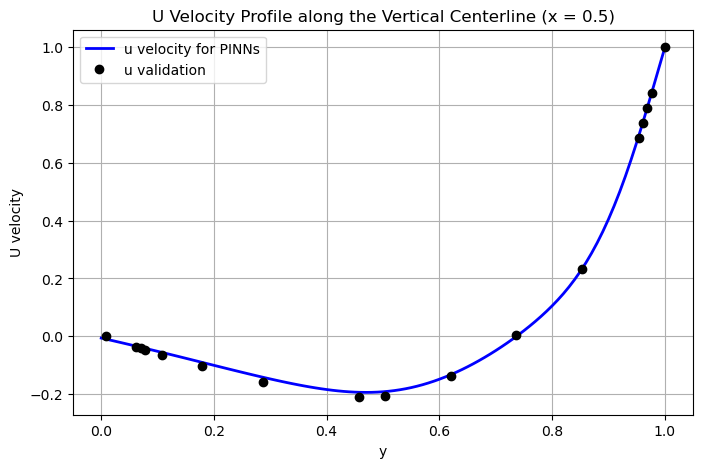

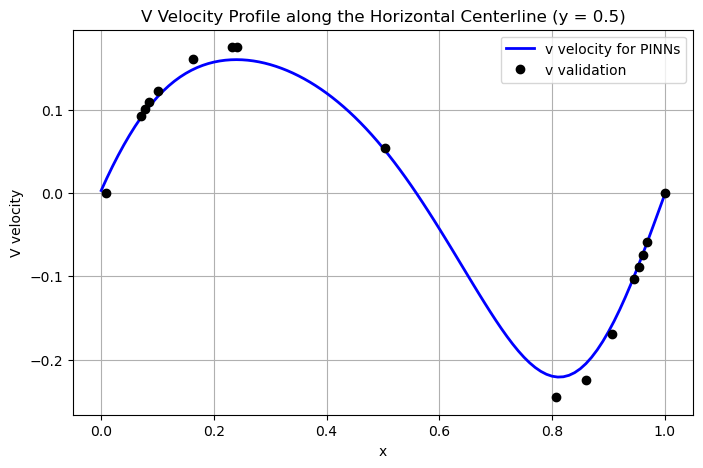

In [24]:
with torch.no_grad():
    uvp_pred = net.network(net.X).reshape(len(net.x), len(net.y), 3)

u = uvp_pred[:, :, 0].detach().cpu().numpy()
v = uvp_pred[:, :, 1].detach().cpu().numpy()

# Plot u velocity along vertical centerline (x = 0.5)
plt.figure(figsize=(8, 5))
center_idx_x = len(net.x) // 2
plt.plot(net.y.cpu(), u[center_idx_x, :], 'b-', linewidth=2, label='u velocity for PINNs')
plt.plot(x_validation, u_validation2, 'ko', label="u validation", markersize=6, linewidth=2)
plt.xlabel("y")
plt.ylabel("U velocity")
plt.title("U Velocity Profile along the Vertical Centerline (x = 0.5)")
plt.legend()
plt.grid(True)
plt.show()

# Plot v velocity along horizontal centerline (y = 0.5)
plt.figure(figsize=(8, 5))
center_idx_y = len(net.y) // 2
plt.plot(net.x.cpu(), v[:, center_idx_y], 'b-', linewidth=2, label='v velocity for PINNs')
plt.plot(y_validation, v_validation2, 'ko', label="v validation", markersize=6, linewidth=2)
plt.xlabel("x")
plt.ylabel("V velocity")
plt.title("V Velocity Profile along the Horizontal Centerline (y = 0.5)")
plt.legend()
plt.grid(True)
plt.show()